## ●파생변수 생성
#### 1. 파생변수 변환
#### 2. 변수변환 파일 생성
#### 3. 정규화
#### 4_1. Kmeans 유클리드
#### 4_2. Kmeans 코싸인

In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm_notebook
import platform
import matplotlib.pyplot as plt
import seaborn as sns
import copy

%matplotlib inline

path = "c:/Windows/Fonts/malgun.ttf"
from matplotlib import font_manager,rc
if platform.system() == 'Windows' :
    font_name = font_manager.FontProperties(fname=path).get_name()
    rc('font', family=font_name)
plt.rcParams['axes.unicode_minus'] = False

In [25]:
#df = pd.read_excel("./../9 - Data/인테리어비용제외.xlsx")
df = pd.read_excel("./data/결측치제외.xlsx")

pd.get_dummies(df.중분류).head()
df = pd.concat([df,pd.get_dummies(df.중분류)],axis=1)


### 부채비율의 '완전자본잠식'을 '-1'로 표시, 값이 무한대인 것이 있어 부채,자본에 각각 +1을 한 후 비율 계산

In [26]:
for i in tqdm_notebook(range(len(df))):
    if 0 < (df['부채'][i]+1)/(df['자본'][i]+1) < np.inf:
        df['부채비율'][i] = (df['부채'][i]+1)/(df['자본'][i]+1)
    else : 
        df['부채비율'][i]  = -1

C:\Users\ce401Prof\bigdata\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\ce401Prof\bigdata\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


### 자기자본비율의 '완전자본잠식'을 '-1'로 표시

In [27]:
for i in tqdm_notebook(range(len(df))):
    if df['자본'][i]/df['자산'][i] > 0:
        df['자기자본비율'][i] = df['자기자본비율'][i]
    else : 
        df['자기자본비율'][i]  = -1

C:\Users\ce401Prof\bigdata\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\ce401Prof\bigdata\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


In [6]:
df.to_excel('./data/부채자본수정.xlsx')

In [32]:
df[['가맹점 수', '부채비율', '자기자본비율','계약해지','신규개점']].describe()

,가맹점 수,부채비율,자기자본비율,계약해지,신규개점
count,1555.000000,1555.000000,1555.000000,1555.000000,1555.000000
mean,0.668907,1.876388,0.357155,5.608360,12.070740
std,0.706253,2.466197,0.732543,12.651972,27.157985
min,0.016667,-1.000000,-1.000000,0.000000,0.000000
25%,0.166667,0.229816,0.138986,0.000000,1.000000
50%,0.333333,1.052819,0.358615,2.000000,5.000000
75%,0.766667,4.128127,0.955359,6.000000,12.500000
max,2.000000,7.143327,1.663418,184.000000,639.000000


In [8]:
df.columns

Index(['브랜드', '가맹점 수', '신규개점', '계약종료', '계약해지', '자산', '매출액', '영업이익', '자본',
       '당기순이익', '부채', '부채비율', '자기자본비율', '법위반횟수', '가맹점 매출액', '가맹사업 개월수',
       '비용 합계', '총언급량', '긍정', '중립', '부정', '기타 외국식', '기타 외식', '분식', '서양식',
       '아이스크림/빙수 ', '음료 (커피 외)', '일식', '제과제빵', '주점', '중식', '치킨', '커피', '패스트푸드',
       '피자', '한식'],
      dtype='object')

## 1. 파생변수 변환

In [28]:
# 가맹점수 연결함수에 의해 가중치 부여
x = df['가맹점 수'].values; x = x.tolist()
for i in range (len(x)):
    if x[i] >= 60 : x[i] = 2
    else : x[i] = float(x[i]/60)
df['가맹점 수'] = x

# 자가자본비율 연결함수에 의해 가중치 부여
y = df['자기자본비율'].values; y = y.tolist()
for i in range(len(y)):
    if y[i] >= np.percentile(y,75) : y[i] = np.percentile(y,75) + (np.percentile(y,75)-np.percentile(y,25))*1.5 
    else : y[i] = y[i]
df['자기자본비율'] = y

# 부채비율 연결함수에 의해 가중치부여
z = df['부채비율'].values; z = z.tolist()
for i in range(len(z)):
    if z[i] >=  np.percentile(z,75) : z[i] = np.percentile(z,75) + (np.percentile(z,75)-np.percentile(z,25))*1.5
    else : z[i] = z[i]
df['부채비율'] = z

# 해지율 스케일링 (0~1 사이로 바꿔줌)
from sklearn.preprocessing import scale, robust_scale, minmax_scale, maxabs_scale
df['해지율'] = (df['계약해지']+1)/(df['신규개점']+1)
w= df['해지율'].values.tolist()
w = minmax_scale(w)
df['해지율'] = w   # 0~1 사이값으로 변경

In [10]:
df[['가맹점 수', '부채비율', '자기자본비율','해지율']].describe()

,가맹점 수,부채비율,자기자본비율,해지율
count,1555.000000,1555.000000,1555.000000,1555.000000
mean,0.668907,1.876388,0.357155,0.045633
std,0.706253,2.466197,0.732543,0.082805
min,0.016667,-1.000000,-1.000000,0.000000
25%,0.166667,0.229816,0.138986,0.005723
50%,0.333333,1.052819,0.358615,0.016617
75%,0.766667,4.128127,0.955359,0.044714
max,2.000000,7.143327,1.663418,1.000000


In [29]:
#기본 파생변수 5개  - 원준 작성
df['평판'] = (df['긍정']+1)/(df['총언급량']+1)
df['성장성'] = (df['신규개점'] / (df['가맹점 수'] +df['계약해지'] +df['계약종료']))
df['본사의신용도'] = np.exp(-(df['부채비율'] + (df['법위반횟수'] * 0.001)))
df['안정성'] = (df['가맹점 수']) - (df['해지율']) - (df['부채비율']) + (df['자기자본비율']) 
df['안정성'] -= np.min(df['안정성'])
df['창업대비매출'] = df['가맹점 매출액'] / df['비용 합계']
df['개월수']=df['가맹사업 개월수']
# df['인지도'] = np.log(df['총언급량']+1) 제외하기로 함


# 본사의 신용도는 부채비율,법위반횟수가 클수록 안좋은것.
# 즉 우변을 감소함수로 감싸줘야함. (0,0)은 1값을 최대로 하는 감소함수? --> exp(-x)

# (df['가맹점수'] / 60) 는 relu함수같이 60 이상은 똑같이 이하에서는 패널티먹게끔.  부채비율과 자기자본비율의 기준 알아내기
# 보통 자가자본비율이 8~10% 이상이면 준수하다고 봄  --> 0.08 이상에서는 상수, 이하에서는 감소하는 함수 사용
# 부채비율은 200% 까지는 안정적이라 봄 -> 2이상은 패널티 값 부여, 2이하는 0값으로 빼주기

In [12]:
#check
np.min(df['안정성'])

0.0

In [13]:
df0 = copy.deepcopy(df)
df3 = df0.iloc[:,[0,-6,-5,-4,-3,-2,-1]]
df3.columns = ['Brand','Brand Value','Growth','Enterprise Credit','Stability','Profit','Period']
df3.describe()

,Brand Value,Growth,Enterprise Credit,Stability,Profit,Period
count,1555.000000,1555.000000,1555.000000,1555.000000,1555.000000,1555.000000
mean,0.895394,8.820126,0.708501,6.004252,3.376808,90.049518
std,0.131861,16.846647,0.919190,2.679844,4.503833,62.326450
min,0.032865,0.000000,0.000790,0.000000,0.025235,20.000000
25%,0.869980,0.269795,0.044483,4.021096,1.748409,45.000000
50%,0.930348,1.200000,0.348953,6.915319,2.798800,73.000000
75%,1.000000,5.954198,0.794680,8.001460,4.053476,115.500000
max,1.000000,69.500000,2.718282,10.201542,142.629545,493.000000


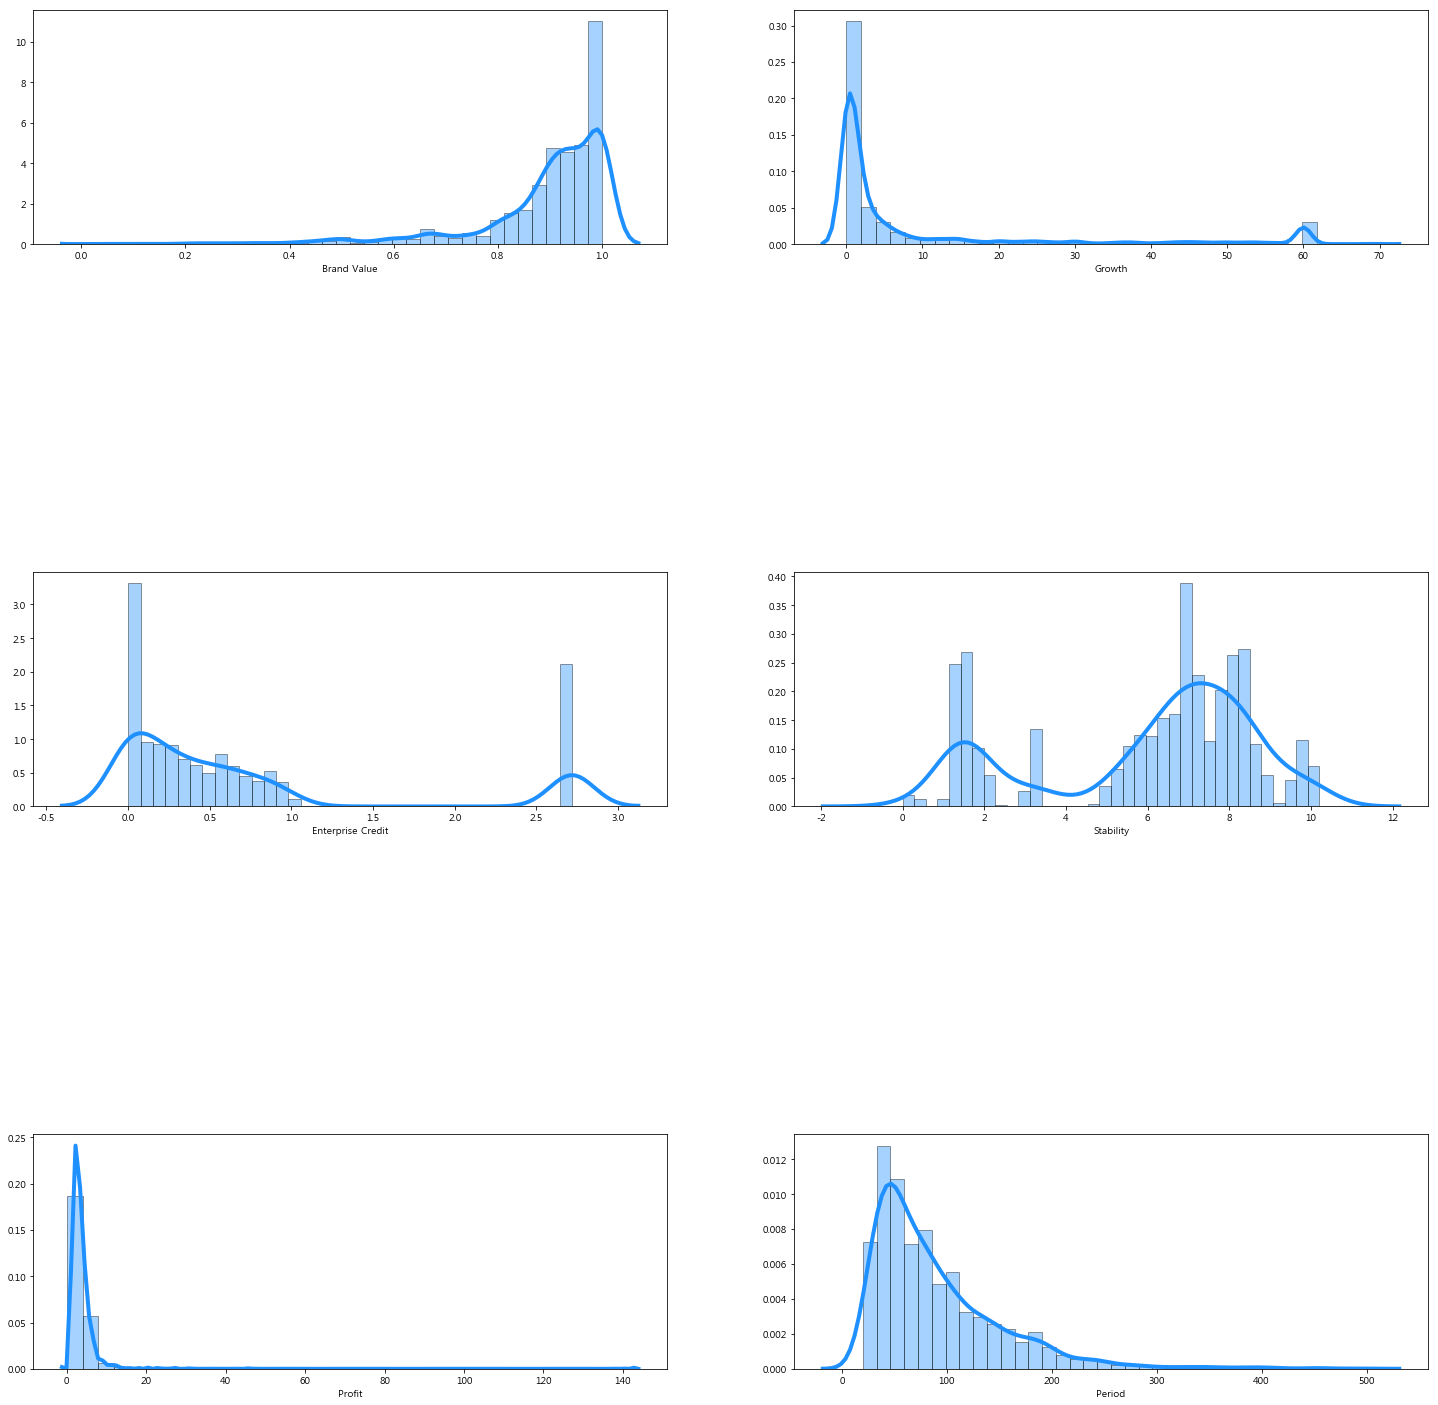

In [14]:
# 보정 없는 상태로 그래프 확인

plt.figure(figsize=(25,25))

plt.subplot(5,2,1)
sns.distplot(df3['Brand Value'], hist=True, kde=True, 
             bins=int(180/5), color = 'dodgerblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})
plt.savefig('평판')


plt.subplot(5,2,2)
sns.distplot(df3['Growth'], hist=True, kde=True, 
             bins=int(180/5), color = 'dodgerblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})
plt.savefig('성장성')

plt.subplot(5,2,5)
sns.distplot(df3['Enterprise Credit'], hist=True, kde=True, 
             bins=int(180/5), color = 'dodgerblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})
plt.savefig('본사의신용도')

plt.subplot(5,2,6)
sns.distplot(df3['Stability'], hist=True, kde=True, 
             bins=int(180/5), color = 'dodgerblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})
plt.savefig('안정성')

plt.subplot(5,2,9)
sns.distplot(df3['Profit'], hist=True, kde=True, 
             bins=int(180/5), color = 'dodgerblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})
plt.savefig('비용대비매출')

plt.subplot(5,2,10)
sns.distplot(df3['Period'], hist=True, kde=True, 
             bins=int(180/5), color = 'dodgerblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})
plt.savefig('개월수')

plt.show()

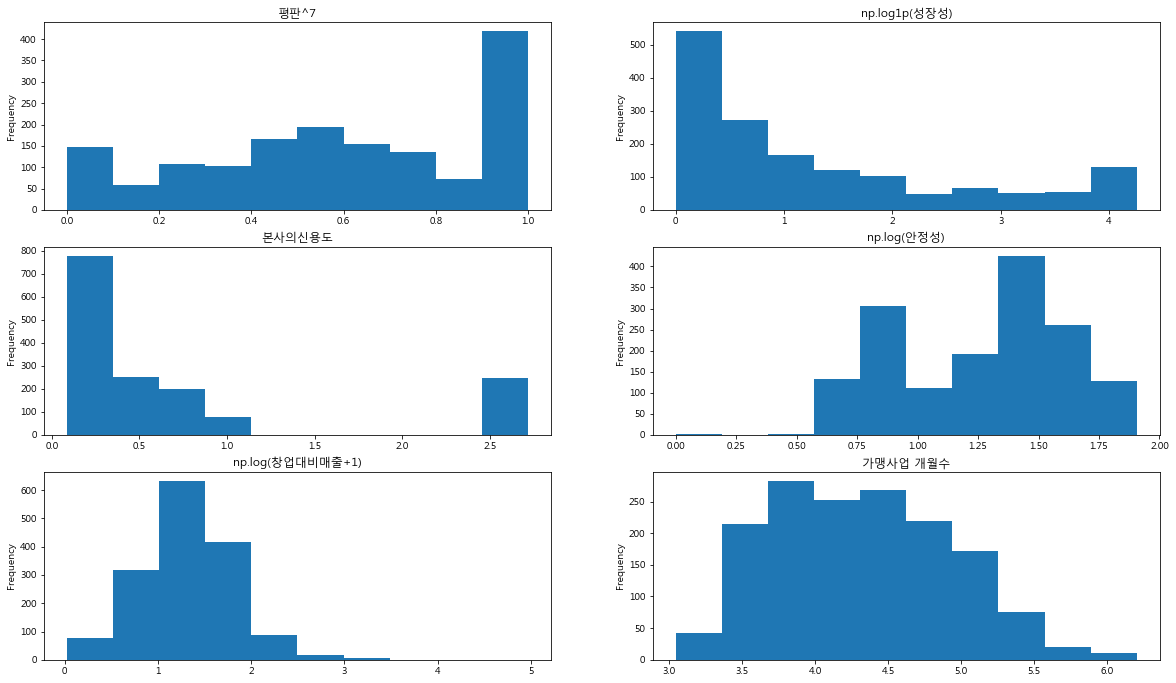

In [44]:
# 정규성 보정 들어간 식

plt.figure(figsize=(20,20))

plt.subplot(5,2,1)
np.power(df['평판'],7).plot.hist()
plt.title('평판^7')

plt.subplot(5,2,2)
np.log1p(df['성장성']).plot.hist()
plt.title('np.log1p(성장성)')

plt.subplot(5,2,3)
df['본사의신용도'].plot.hist()
plt.title('본사의신용도')

plt.subplot(5,2,4)
np.log(df['안정성']+1).plot.hist()
plt.title('np.log(안정성)')

plt.subplot(5,2,5)
np.log(df['창업대비매출']+1).plot.hist()
plt.title('np.log(창업대비매출+1)')

plt.subplot(5,2,6)
np.log(df['가맹사업 개월수']+1).plot.hist()
plt.title('가맹사업 개월수')

plt.show()

In [30]:
df['평판'] = np.power(df['평판'],7)
df['성장성'] = np.log1p(df['성장성'])
df['본사의신용도'] = df['본사의신용도']
df['안정성'] = np.log(df['안정성']+1)
df['창업대비매출'] = np.log(df['창업대비매출']+1)

In [31]:
df.to_csv('./data/francise.csv',encoding='CP949')

## 2. 변수변환 파일 생성

In [17]:
df1 = df.iloc[:,[0,-6,-5,-4,-3,-2,-1]]
df2 = df.iloc[:,-6:]
df1.head()

,브랜드,평판,성장성,본사의신용도,안정성,창업대비매출,개월수
0,본죽,0.195608,0.535518,0.507901,2.279848,1.395206,187
1,한솥,0.242836,0.748410,0.719533,2.384684,1.458055,301
2,고봉민김밥人,0.233756,1.540445,0.853463,2.401397,1.438183,80
3,큰맘할매순대국,0.719467,1.976063,0.603474,2.369837,1.473456,54
4,바다양푼이 동태탕 찜,1.000000,1.435085,0.833184,2.399974,2.275944,103


In [18]:
df1.columns = ['Brand','Brand Value','Growth','Enterprise Credit','Stability','Profit','Period']

In [19]:
def corrdot(*args, **kwargs):    
    corr_r = args[0].corr(args[1], 'pearson')
    corr_text = f"{corr_r:2.2f}".replace("0.", ".")
    ax = plt.gca()
    ax.set_axis_off()
    marker_size = abs(corr_r) * 10000
    ax.scatter(.5, .5, marker_size, corr_r, alpha=0.6, cmap="coolwarm",
               vmin=-1, vmax=1, transform=ax.transAxes)
    font_size = abs(corr_r) * 40 + 15
    ax.annotate(corr_text, [.5, .5,],  xycoords="axes fraction",
                ha='center', va='center', fontsize=font_size)

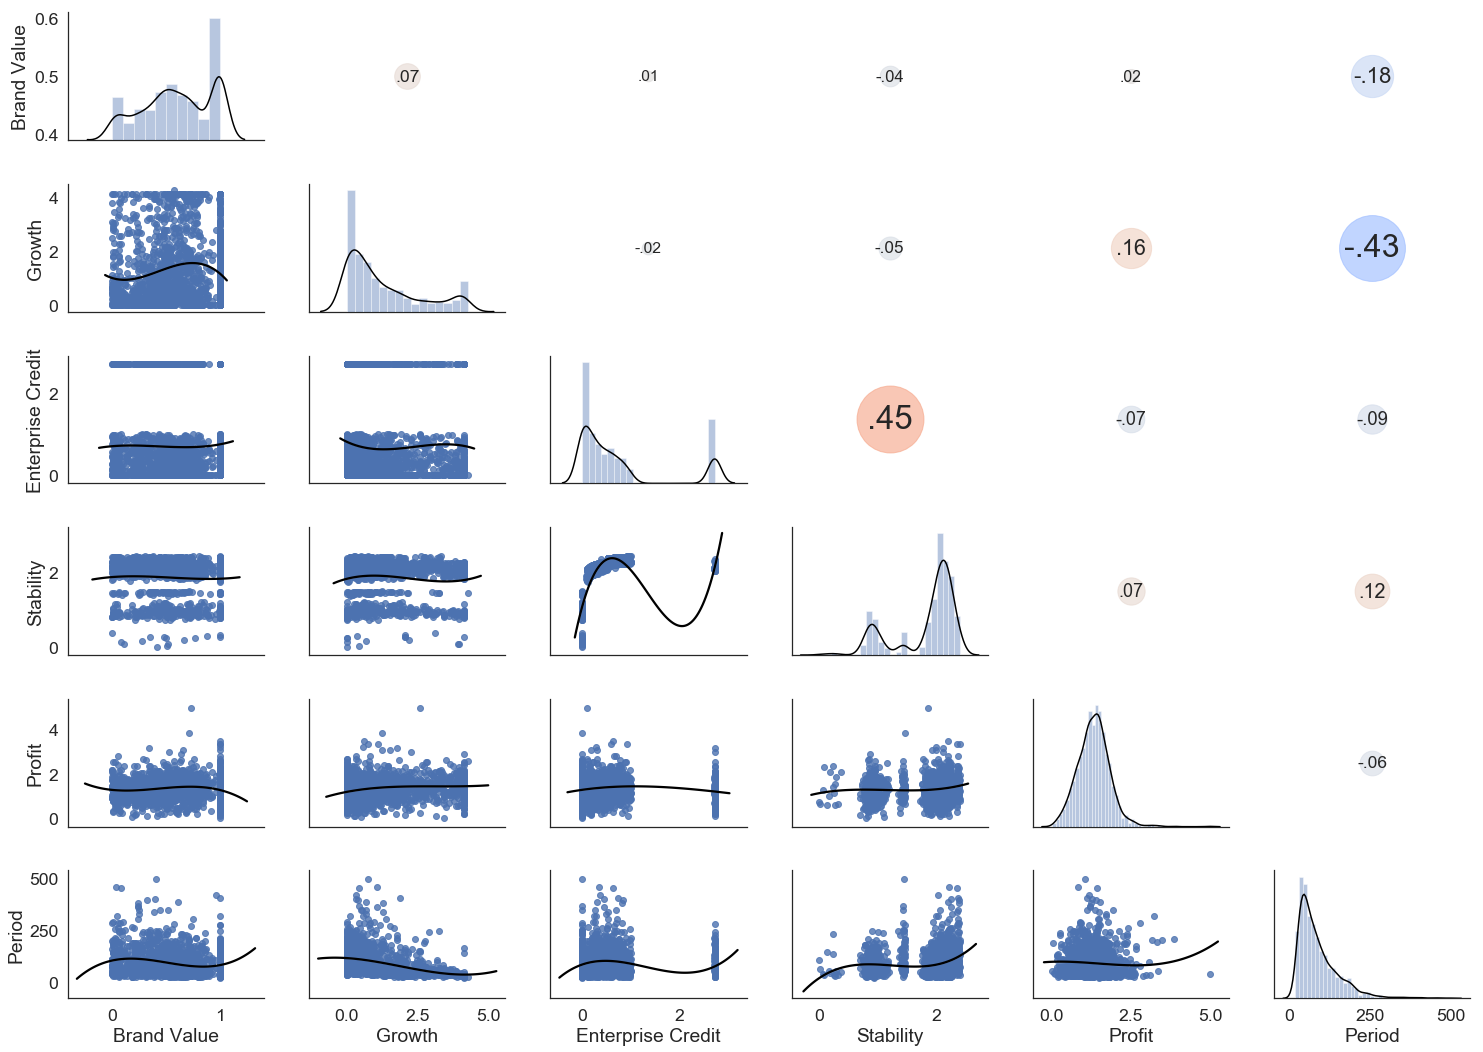

In [20]:
sns.set(style='white', font_scale=1.6)

g = sns.PairGrid(df1, aspect=1.4, diag_sharey=False)
g.map_lower(sns.regplot, order=3, ci=False, line_kws={'color': 'black'})
g.map_diag(sns.distplot, kde_kws={'color': 'black'})
g.map_upper(corrdot)

In [130]:
df1.to_csv('./data/francise_cluter.csv',encoding='CP949',index=False)

## 3. 정규화

In [21]:
df2.head()

,평판,성장성,본사의신용도,안정성,창업대비매출,개월수
0,0.195608,0.535518,0.507901,2.279848,1.395206,187
1,0.242836,0.748410,0.719533,2.384684,1.458055,301
2,0.233756,1.540445,0.853463,2.401397,1.438183,80
3,0.719467,1.976063,0.603474,2.369837,1.473456,54
4,1.000000,1.435085,0.833184,2.399974,2.275944,103


In [22]:
df_values = df2.values
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
df_scaler = scaler.fit_transform(df_values)

## 4_1. Kmeans 유클리드
    엘보우 기법 (x_i-u_i)^2을 활용
    실루엣 기법 (b_i - a_i) / max(a_i,b_i)

In [23]:
from sklearn.cluster.k_means_ import KMeans
from sklearn.cluster import k_means_
import matplotlib.pyplot  as plt
import seaborn as sns
from sklearn.metrics.cluster import silhouette_score

In [24]:
# create model and prediction
sse = []
silhouette = []
for i in range(2,26):
    model = KMeans(n_clusters=int('{0}'.format(i)),algorithm='auto')
    model.fit(df_scaler)
    predict = pd.DataFrame(model.predict(df_scaler))
    predict.columns=['predict']
    sse.append(model.inertia_) #elbow
    silhouette.append(silhouette_score(df_scaler, model.predict(df_scaler)))

    # concatenate labels to df as a new column
    r = pd.concat([pd.DataFrame(df_scaler, columns=df2.columns),predict],axis=1)
    r = pd.concat([df['브랜드'], r], axis=1)
    
    r.to_excel("./data/clust/Kmeans_{0}.xlsx".format(i))

In [ ]:
pd.read

Text(0,0.5,'SSE')

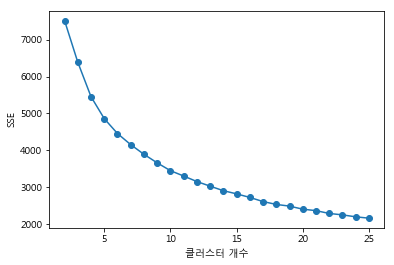

In [21]:
#elbow visualization
plt.plot(range(2,26), sse, marker = 'o' )
plt.xlabel('클러스터 개수')
plt.ylabel('SSE')

Text(0,0.5,'silhoutte mean')

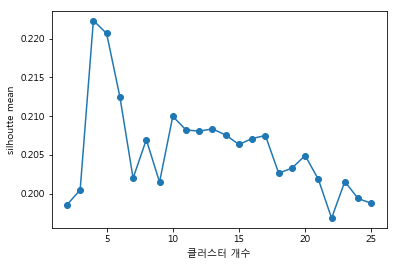

In [22]:
#silhouette visualization
plt.plot(range(2,26), silhouette, marker = 'o' )
plt.xlabel('클러스터 개수')
plt.ylabel('silhoutte mean')

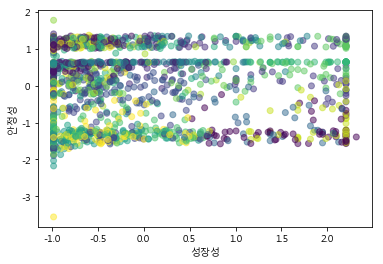

In [23]:
# scatter plot
plt.scatter(r['성장성'],r['안정성'],c=r['predict'],alpha=0.5)
plt.xlabel('성장성')
plt.ylabel('안정성')
plt.show()

## 4_2. Kmeans 코싸인

In [19]:
def KMeans_cosine_fit(sparse_data, nclust = 10, njobs=-1, randomstate=None):
    # Manually override euclidean
    def euc_dist(X, Y = None, Y_norm_squared = None, squared = False):
        #return pairwise_distances(X, Y, metric = 'cosine', n_jobs = 10)
        return np.arccos(cosine_similarity(X, Y))/np.pi
    k_means_.euclidean_distances = euc_dist
    kmeans = k_means_.KMeans(n_clusters = nclust, n_jobs = njobs, random_state = randomstate)
    _ = kmeans.fit(sparse_data)
    return kmeans

Text(0,0.5,'SSE')

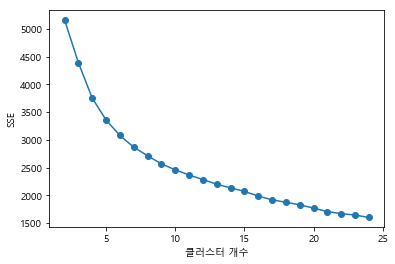

In [20]:
sse = []
silhouette = []
for i in range(2,25):
    model = KMeans_cosine_fit(df_scaler, int('{0}'.format(i)))
    sse.append(model.inertia_) #elbow
    silhouette.append(silhouette_score(df_scaler, model.predict(df_scaler)))
    predict = pd.DataFrame(model.predict(df_scaler))
    predict.columns=['predict']
    

    # concatenate labels to df as a new column
    r = pd.concat([pd.DataFrame(df_scaler, columns=df2.columns),predict],axis=1)
    r = pd.concat([df['브랜드'], r], axis=1)

    r.to_excel("./../9 - Data/Kmeans_cos_{0}.xlsx".format(i))
    
#elbow visualization
plt.plot(range(2,25), sse, marker = 'o' )
plt.xlabel('클러스터 개수')
plt.ylabel('SSE')

Text(0,0.5,'silhoutte mean')

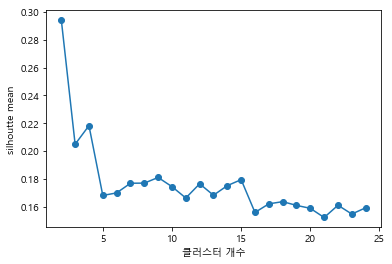

In [27]:
#silhouette visualization
plt.plot(range(2,25), silhouette, marker = 'o' )
plt.xlabel('클러스터 개수')
plt.ylabel('silhoutte mean')

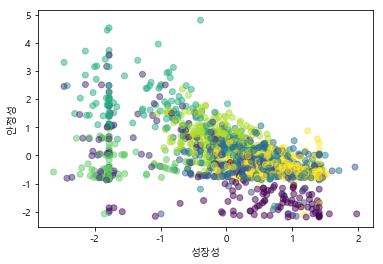

In [20]:
# scatter plot
plt.scatter(r['성장성'],r['안정성'],c=r['predict'],alpha=0.5)
plt.xlabel('성장성')
plt.ylabel('안정성')
plt.show()

## 4_3. AffinityPropagation

In [46]:
from sklearn.cluster import AffinityPropagation

In [61]:
# create model and prediction
silhouette = []

model = AffinityPropagation()
model.fit(df_scaler)
predict = pd.DataFrame(model.predict(df_scaler))
predict.columns=['predict']
silhouette.append(silhouette_score(df_scaler, model.predict(df_scaler)))

# concatenate labels to df as a new column
r = pd.concat([pd.DataFrame(df_scaler, columns=df2.columns),predict],axis=1)
r = pd.concat([df['브랜드'], r], axis=1)

r.to_excel("./../9 - Data/AffinityPropagation_1.xlsx")

In [62]:
silhouette, np.unique(predict)

([0.13635446339488147],
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
        51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
        68, 69, 70, 71, 72, 73, 74, 75, 76], dtype=int64))

## 4_4. Mean Shift

In [52]:
from sklearn.cluster import MeanShift

In [63]:
# create model and prediction
silhouette = []

model = MeanShift()
model.fit(df_scaler)
predict = pd.DataFrame(model.predict(df_scaler))
predict.columns=['predict']
silhouette.append(silhouette_score(df_scaler, model.predict(df_scaler)))

# concatenate labels to df as a new column
r = pd.concat([pd.DataFrame(df_scaler, columns=df2.columns),predict],axis=1)
r = pd.concat([df['브랜드'], r], axis=1)

r.to_excel("./../9 - Data/MeanShift_1.xlsx")

In [64]:
silhouette, np.unique(predict)

([0.41053527905742787], array([0, 1], dtype=int64))

## 4_5. DBSCAN

In [65]:
from sklearn.cluster import DBSCAN

In [68]:
# create model and prediction
silhouette = []

model = DBSCAN()
predict = pd.DataFrame(model.fit_predict(df_scaler))
predict.columns=['predict']
silhouette.append(silhouette_score(df_scaler, model.fit_predict(df_scaler)))

# concatenate labels to df as a new column
r = pd.concat([pd.DataFrame(df_scaler, columns=df2.columns),predict],axis=1)
r = pd.concat([df['브랜드'], r], axis=1)

r.to_excel("./../9 - Data/DBSCAN_1.xlsx")

In [69]:
silhouette, np.unique(predict)

([-0.33514807806693425],
 array([-1,  0,  1,  2,  3,  4,  5,  6,  7], dtype=int64))

## 4_6. SpectralClustering

In [71]:
from sklearn.cluster import SpectralClustering

In [74]:
# create model and prediction
sse = []
silhouette = []
for i in range(2,25):
    model = SpectralClustering(n_clusters=int('{0}'.format(i)))
    predict = pd.DataFrame(model.fit_predict(df_scaler))
    predict.columns=['predict']
    silhouette.append(silhouette_score(df_scaler, model.fit_predict(df_scaler)))

    # concatenate labels to df as a new column
    r = pd.concat([pd.DataFrame(df_scaler, columns=df2.columns),predict],axis=1)
    r = pd.concat([df['브랜드'], r], axis=1)
    
    r.to_excel("./../9 - Data/SpectralClustering_{0}.xlsx".format(i))

Text(0,0.5,'silhoutte mean')

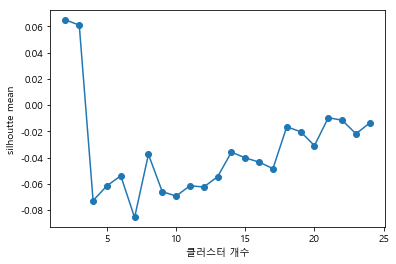

In [75]:
#silhouette visualization
plt.plot(range(2,25), silhouette, marker = 'o' )
plt.xlabel('클러스터 개수')
plt.ylabel('silhoutte mean')

## eg. silhouette

In [ ]:
#silhouette
from sklearn.metrics import silhouette_samples
from matplotlib import cm

def plotSilhouette(X, y_km):
    cluster_labels = np.unique(y_km)
    n_clusters = cluster_labels.shape[0]
    silhouette_vals = silhouette_samples(X, y_km, metric='euclidean')
    y_ax_lower, y_ax_upper = 0, 0
    yticks = []
    
    for i, c in enumerate(cluster_labels) :
        c_silhouette_vals = silhouette_vals[y_km == c]
        c_silhouette_vals.sort()
        y_ax_upper += len(c_silhouette_vals)
        color = cm.jet(i/n_clusters)
        
        plt.barh(range(y_ax_lower, y_ax_upper), c_silhouette_vals, height=1.0,
                edgecolor='none', color = color)
        yticks.append((y_ax_lower + y_ax_upper)/2)
        y_ax_lower += len(c_silhouette_vals)
    
    silhouette_avg = np.mean(silhouette_vals)
    plt.axvline(silhouette_avg, color='red', linestyle='--')
    plt.yticks(yticks, cluster_labels+1)
    plt.ylabel('클러스터')
    plt.xlabel('실루엣 계수')
    plt.show()
    
plotSilhouette(df_scaler, model.predict(df_scaler))